# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import model
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce GTX 1650 Ti with Max-Q Design')

In [3]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 45
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [5]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [6]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 10:-10,:]
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 10:-10,:]
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [7]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [8]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [9]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [10]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


100%|██████████| 144/144 [02:58<00:00,  1.24s/it]


[INFO] EPOCH: 1/100
Train loss: 0.626928, Test loss: 0.5296, Train IoU: 0.2385, Test IoU: 0.3295, Train Dice: 0.3801, Test Dice: 0.4990


100%|██████████| 144/144 [02:07<00:00,  1.13it/s]


[INFO] EPOCH: 2/100
Train loss: 0.405877, Test loss: 0.3322, Train IoU: 0.4314, Test IoU: 0.5268, Train Dice: 0.6011, Test Dice: 0.6964


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 3/100
Train loss: 0.267100, Test loss: 0.2202, Train IoU: 0.5861, Test IoU: 0.6662, Train Dice: 0.7399, Test Dice: 0.8084


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 4/100
Train loss: 0.190068, Test loss: 0.1667, Train IoU: 0.6884, Test IoU: 0.7430, Train Dice: 0.8169, Test Dice: 0.8619


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 5/100
Train loss: 0.155561, Test loss: 0.1539, Train IoU: 0.7391, Test IoU: 0.7622, Train Dice: 0.8514, Test Dice: 0.8746


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 6/100
Train loss: 0.141233, Test loss: 0.1398, Train IoU: 0.7609, Test IoU: 0.7839, Train Dice: 0.8658, Test Dice: 0.8887


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 7/100
Train loss: 0.133501, Test loss: 0.1351, Train IoU: 0.7729, Test IoU: 0.7912, Train Dice: 0.8735, Test Dice: 0.8935


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 8/100
Train loss: 0.128203, Test loss: 0.1294, Train IoU: 0.7811, Test IoU: 0.8001, Train Dice: 0.8788, Test Dice: 0.8991


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 9/100
Train loss: 0.124097, Test loss: 0.1282, Train IoU: 0.7876, Test IoU: 0.8019, Train Dice: 0.8829, Test Dice: 0.9003


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 10/100
Train loss: 0.121970, Test loss: 0.1238, Train IoU: 0.7908, Test IoU: 0.8088, Train Dice: 0.8850, Test Dice: 0.9047


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 11/100
Train loss: 0.119375, Test loss: 0.1226, Train IoU: 0.7949, Test IoU: 0.8106, Train Dice: 0.8876, Test Dice: 0.9059


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 12/100
Train loss: 0.117693, Test loss: 0.1215, Train IoU: 0.7975, Test IoU: 0.8124, Train Dice: 0.8893, Test Dice: 0.9071


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 13/100
Train loss: 0.116099, Test loss: 0.1128, Train IoU: 0.8002, Test IoU: 0.8270, Train Dice: 0.8909, Test Dice: 0.9158


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 14/100
Train loss: 0.105193, Test loss: 0.1061, Train IoU: 0.8180, Test IoU: 0.8374, Train Dice: 0.9018, Test Dice: 0.9224


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 15/100
Train loss: 0.102052, Test loss: 0.1027, Train IoU: 0.8229, Test IoU: 0.8431, Train Dice: 0.9049, Test Dice: 0.9259


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 16/100
Train loss: 0.099985, Test loss: 0.1016, Train IoU: 0.8263, Test IoU: 0.8447, Train Dice: 0.9070, Test Dice: 0.9270


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 17/100
Train loss: 0.098958, Test loss: 0.1006, Train IoU: 0.8279, Test IoU: 0.8465, Train Dice: 0.9080, Test Dice: 0.9280


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 18/100
Train loss: 0.097883, Test loss: 0.1002, Train IoU: 0.8297, Test IoU: 0.8470, Train Dice: 0.9091, Test Dice: 0.9283


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 19/100
Train loss: 0.097150, Test loss: 0.0995, Train IoU: 0.8309, Test IoU: 0.8482, Train Dice: 0.9098, Test Dice: 0.9291


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 20/100
Train loss: 0.096904, Test loss: 0.0991, Train IoU: 0.8313, Test IoU: 0.8488, Train Dice: 0.9101, Test Dice: 0.9295


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 21/100
Train loss: 0.095543, Test loss: 0.0977, Train IoU: 0.8334, Test IoU: 0.8511, Train Dice: 0.9115, Test Dice: 0.9308


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 22/100
Train loss: 0.095115, Test loss: 0.0986, Train IoU: 0.8342, Test IoU: 0.8496, Train Dice: 0.9119, Test Dice: 0.9300


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 23/100
Train loss: 0.094954, Test loss: 0.0977, Train IoU: 0.8345, Test IoU: 0.8509, Train Dice: 0.9120, Test Dice: 0.9308


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 24/100
Train loss: 0.094540, Test loss: 0.0970, Train IoU: 0.8351, Test IoU: 0.8523, Train Dice: 0.9125, Test Dice: 0.9316


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 25/100
Train loss: 0.094293, Test loss: 0.0962, Train IoU: 0.8355, Test IoU: 0.8536, Train Dice: 0.9127, Test Dice: 0.9324


100%|██████████| 144/144 [01:54<00:00,  1.25it/s]


[INFO] EPOCH: 26/100
Train loss: 0.093281, Test loss: 0.0965, Train IoU: 0.8371, Test IoU: 0.8530, Train Dice: 0.9137, Test Dice: 0.9320


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 27/100
Train loss: 0.093447, Test loss: 0.0960, Train IoU: 0.8368, Test IoU: 0.8537, Train Dice: 0.9135, Test Dice: 0.9325


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 28/100
Train loss: 0.092659, Test loss: 0.0964, Train IoU: 0.8381, Test IoU: 0.8531, Train Dice: 0.9143, Test Dice: 0.9322


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 29/100
Train loss: 0.092772, Test loss: 0.0957, Train IoU: 0.8379, Test IoU: 0.8542, Train Dice: 0.9142, Test Dice: 0.9328


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 30/100
Train loss: 0.093129, Test loss: 0.0958, Train IoU: 0.8373, Test IoU: 0.8541, Train Dice: 0.9139, Test Dice: 0.9328


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 31/100
Train loss: 0.090532, Test loss: 0.0897, Train IoU: 0.8418, Test IoU: 0.8646, Train Dice: 0.9165, Test Dice: 0.9388


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 32/100
Train loss: 0.081796, Test loss: 0.0823, Train IoU: 0.8567, Test IoU: 0.8771, Train Dice: 0.9252, Test Dice: 0.9463


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 33/100
Train loss: 0.076955, Test loss: 0.0799, Train IoU: 0.8650, Test IoU: 0.8812, Train Dice: 0.9300, Test Dice: 0.9487


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 34/100
Train loss: 0.074860, Test loss: 0.0778, Train IoU: 0.8686, Test IoU: 0.8847, Train Dice: 0.9321, Test Dice: 0.9508


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 35/100
Train loss: 0.073785, Test loss: 0.0767, Train IoU: 0.8705, Test IoU: 0.8867, Train Dice: 0.9332, Test Dice: 0.9519


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 36/100
Train loss: 0.072182, Test loss: 0.0765, Train IoU: 0.8731, Test IoU: 0.8869, Train Dice: 0.9348, Test Dice: 0.9521


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 37/100
Train loss: 0.071792, Test loss: 0.0768, Train IoU: 0.8738, Test IoU: 0.8865, Train Dice: 0.9352, Test Dice: 0.9518


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 38/100
Train loss: 0.070972, Test loss: 0.0747, Train IoU: 0.8752, Test IoU: 0.8901, Train Dice: 0.9360, Test Dice: 0.9539


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 39/100
Train loss: 0.070115, Test loss: 0.0745, Train IoU: 0.8767, Test IoU: 0.8904, Train Dice: 0.9369, Test Dice: 0.9541


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 40/100
Train loss: 0.070371, Test loss: 0.0747, Train IoU: 0.8763, Test IoU: 0.8900, Train Dice: 0.9366, Test Dice: 0.9539


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 41/100
Train loss: 0.069580, Test loss: 0.0742, Train IoU: 0.8776, Test IoU: 0.8908, Train Dice: 0.9374, Test Dice: 0.9543


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 42/100
Train loss: 0.069170, Test loss: 0.0734, Train IoU: 0.8783, Test IoU: 0.8923, Train Dice: 0.9378, Test Dice: 0.9552


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 43/100
Train loss: 0.063697, Test loss: 0.0565, Train IoU: 0.8881, Test IoU: 0.9221, Train Dice: 0.9433, Test Dice: 0.9721


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 44/100
Train loss: 0.051496, Test loss: 0.0524, Train IoU: 0.9097, Test IoU: 0.9295, Train Dice: 0.9555, Test Dice: 0.9762


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 45/100
Train loss: 0.049352, Test loss: 0.0518, Train IoU: 0.9135, Test IoU: 0.9305, Train Dice: 0.9576, Test Dice: 0.9767


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 46/100
Train loss: 0.047989, Test loss: 0.0514, Train IoU: 0.9160, Test IoU: 0.9312, Train Dice: 0.9590, Test Dice: 0.9772


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 47/100
Train loss: 0.047994, Test loss: 0.0507, Train IoU: 0.9160, Test IoU: 0.9325, Train Dice: 0.9590, Test Dice: 0.9778


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 48/100
Train loss: 0.047092, Test loss: 0.0498, Train IoU: 0.9175, Test IoU: 0.9340, Train Dice: 0.9599, Test Dice: 0.9787


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 49/100
Train loss: 0.047113, Test loss: 0.0499, Train IoU: 0.9175, Test IoU: 0.9338, Train Dice: 0.9599, Test Dice: 0.9786


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 50/100
Train loss: 0.047353, Test loss: 0.0503, Train IoU: 0.9170, Test IoU: 0.9332, Train Dice: 0.9596, Test Dice: 0.9783


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 51/100
Train loss: 0.046973, Test loss: 0.0501, Train IoU: 0.9177, Test IoU: 0.9335, Train Dice: 0.9600, Test Dice: 0.9785


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 52/100
Train loss: 0.046379, Test loss: 0.0499, Train IoU: 0.9188, Test IoU: 0.9339, Train Dice: 0.9606, Test Dice: 0.9787


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 53/100
Train loss: 0.046503, Test loss: 0.0500, Train IoU: 0.9185, Test IoU: 0.9335, Train Dice: 0.9605, Test Dice: 0.9785


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 54/100
Train loss: 0.046385, Test loss: 0.0497, Train IoU: 0.9188, Test IoU: 0.9342, Train Dice: 0.9606, Test Dice: 0.9789


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 55/100
Train loss: 0.046186, Test loss: 0.0490, Train IoU: 0.9191, Test IoU: 0.9355, Train Dice: 0.9608, Test Dice: 0.9796


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 56/100
Train loss: 0.045597, Test loss: 0.0487, Train IoU: 0.9202, Test IoU: 0.9360, Train Dice: 0.9614, Test Dice: 0.9799


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 57/100
Train loss: 0.045207, Test loss: 0.0487, Train IoU: 0.9209, Test IoU: 0.9360, Train Dice: 0.9618, Test Dice: 0.9799


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 58/100
Train loss: 0.045173, Test loss: 0.0483, Train IoU: 0.9209, Test IoU: 0.9366, Train Dice: 0.9618, Test Dice: 0.9802


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 59/100
Train loss: 0.045072, Test loss: 0.0491, Train IoU: 0.9211, Test IoU: 0.9353, Train Dice: 0.9619, Test Dice: 0.9795


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 60/100
Train loss: 0.045249, Test loss: 0.0497, Train IoU: 0.9208, Test IoU: 0.9342, Train Dice: 0.9617, Test Dice: 0.9789


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 61/100
Train loss: 0.045113, Test loss: 0.0485, Train IoU: 0.9210, Test IoU: 0.9363, Train Dice: 0.9619, Test Dice: 0.9800


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 62/100
Train loss: 0.045197, Test loss: 0.0490, Train IoU: 0.9209, Test IoU: 0.9354, Train Dice: 0.9618, Test Dice: 0.9795


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 63/100
Train loss: 0.045097, Test loss: 0.0483, Train IoU: 0.9211, Test IoU: 0.9367, Train Dice: 0.9619, Test Dice: 0.9803


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 64/100
Train loss: 0.044619, Test loss: 0.0483, Train IoU: 0.9219, Test IoU: 0.9367, Train Dice: 0.9624, Test Dice: 0.9803


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 65/100
Train loss: 0.044354, Test loss: 0.0479, Train IoU: 0.9224, Test IoU: 0.9373, Train Dice: 0.9626, Test Dice: 0.9806


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 66/100
Train loss: 0.044230, Test loss: 0.0486, Train IoU: 0.9226, Test IoU: 0.9361, Train Dice: 0.9628, Test Dice: 0.9799


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 67/100
Train loss: 0.044286, Test loss: 0.0478, Train IoU: 0.9225, Test IoU: 0.9375, Train Dice: 0.9627, Test Dice: 0.9807


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 68/100
Train loss: 0.043958, Test loss: 0.0480, Train IoU: 0.9231, Test IoU: 0.9373, Train Dice: 0.9630, Test Dice: 0.9806


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 69/100
Train loss: 0.044533, Test loss: 0.0478, Train IoU: 0.9221, Test IoU: 0.9375, Train Dice: 0.9625, Test Dice: 0.9807


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 70/100
Train loss: 0.044644, Test loss: 0.0485, Train IoU: 0.9219, Test IoU: 0.9364, Train Dice: 0.9623, Test Dice: 0.9801


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 71/100
Train loss: 0.044412, Test loss: 0.0500, Train IoU: 0.9223, Test IoU: 0.9336, Train Dice: 0.9626, Test Dice: 0.9786


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 72/100
Train loss: 0.045411, Test loss: 0.0492, Train IoU: 0.9205, Test IoU: 0.9351, Train Dice: 0.9616, Test Dice: 0.9794


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 73/100
Train loss: 0.044008, Test loss: 0.0471, Train IoU: 0.9230, Test IoU: 0.9388, Train Dice: 0.9630, Test Dice: 0.9815


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 74/100
Train loss: 0.043027, Test loss: 0.0472, Train IoU: 0.9248, Test IoU: 0.9387, Train Dice: 0.9640, Test Dice: 0.9814


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 75/100
Train loss: 0.043315, Test loss: 0.0468, Train IoU: 0.9243, Test IoU: 0.9393, Train Dice: 0.9637, Test Dice: 0.9817


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 76/100
Train loss: 0.043631, Test loss: 0.0474, Train IoU: 0.9237, Test IoU: 0.9382, Train Dice: 0.9634, Test Dice: 0.9811


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 77/100
Train loss: 0.043462, Test loss: 0.0475, Train IoU: 0.9240, Test IoU: 0.9380, Train Dice: 0.9635, Test Dice: 0.9810


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 78/100
Train loss: 0.043703, Test loss: 0.0473, Train IoU: 0.9236, Test IoU: 0.9385, Train Dice: 0.9633, Test Dice: 0.9813


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 79/100
Train loss: 0.043336, Test loss: 0.0476, Train IoU: 0.9243, Test IoU: 0.9380, Train Dice: 0.9637, Test Dice: 0.9810


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 80/100
Train loss: 0.043278, Test loss: 0.0468, Train IoU: 0.9244, Test IoU: 0.9393, Train Dice: 0.9637, Test Dice: 0.9817


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 81/100
Train loss: 0.043124, Test loss: 0.0471, Train IoU: 0.9246, Test IoU: 0.9389, Train Dice: 0.9639, Test Dice: 0.9815


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 82/100
Train loss: 0.043273, Test loss: 0.0472, Train IoU: 0.9244, Test IoU: 0.9387, Train Dice: 0.9637, Test Dice: 0.9814


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 83/100
Train loss: 0.043116, Test loss: 0.0469, Train IoU: 0.9246, Test IoU: 0.9393, Train Dice: 0.9639, Test Dice: 0.9817


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 84/100
Train loss: 0.042971, Test loss: 0.0478, Train IoU: 0.9249, Test IoU: 0.9376, Train Dice: 0.9640, Test Dice: 0.9808


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 85/100
Train loss: 0.043318, Test loss: 0.0473, Train IoU: 0.9243, Test IoU: 0.9384, Train Dice: 0.9637, Test Dice: 0.9812


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 86/100
Train loss: 0.043437, Test loss: 0.0473, Train IoU: 0.9241, Test IoU: 0.9384, Train Dice: 0.9636, Test Dice: 0.9812


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 87/100
Train loss: 0.042945, Test loss: 0.0465, Train IoU: 0.9249, Test IoU: 0.9399, Train Dice: 0.9640, Test Dice: 0.9820


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 88/100
Train loss: 0.042748, Test loss: 0.0470, Train IoU: 0.9253, Test IoU: 0.9390, Train Dice: 0.9642, Test Dice: 0.9815


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 89/100
Train loss: 0.042822, Test loss: 0.0468, Train IoU: 0.9252, Test IoU: 0.9394, Train Dice: 0.9642, Test Dice: 0.9818


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 90/100
Train loss: 0.042478, Test loss: 0.0473, Train IoU: 0.9258, Test IoU: 0.9385, Train Dice: 0.9645, Test Dice: 0.9813


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 91/100
Train loss: 0.042891, Test loss: 0.0468, Train IoU: 0.9251, Test IoU: 0.9394, Train Dice: 0.9641, Test Dice: 0.9818


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 92/100
Train loss: 0.043296, Test loss: 0.0472, Train IoU: 0.9243, Test IoU: 0.9386, Train Dice: 0.9637, Test Dice: 0.9814


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 93/100
Train loss: 0.042654, Test loss: 0.0469, Train IoU: 0.9255, Test IoU: 0.9392, Train Dice: 0.9643, Test Dice: 0.9817


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 94/100
Train loss: 0.043481, Test loss: 0.0475, Train IoU: 0.9240, Test IoU: 0.9380, Train Dice: 0.9635, Test Dice: 0.9810


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 95/100
Train loss: 0.042637, Test loss: 0.0467, Train IoU: 0.9255, Test IoU: 0.9395, Train Dice: 0.9644, Test Dice: 0.9818


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 96/100
Train loss: 0.042464, Test loss: 0.0466, Train IoU: 0.9258, Test IoU: 0.9398, Train Dice: 0.9645, Test Dice: 0.9820


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 97/100
Train loss: 0.042049, Test loss: 0.0462, Train IoU: 0.9266, Test IoU: 0.9404, Train Dice: 0.9649, Test Dice: 0.9824


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 98/100
Train loss: 0.041941, Test loss: 0.0461, Train IoU: 0.9268, Test IoU: 0.9406, Train Dice: 0.9651, Test Dice: 0.9824


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 99/100
Train loss: 0.042049, Test loss: 0.0463, Train IoU: 0.9266, Test IoU: 0.9402, Train Dice: 0.9649, Test Dice: 0.9822


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 100/100
Train loss: 0.042029, Test loss: 0.0464, Train IoU: 0.9266, Test IoU: 0.9400, Train Dice: 0.9650, Test Dice: 0.9821
[INFO] total time taken to train the model: 13837.82s


In [10]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformer.pth')
uformer.load_state_dict(torch.load('../models/uformer.pth'))

<All keys matched successfully>

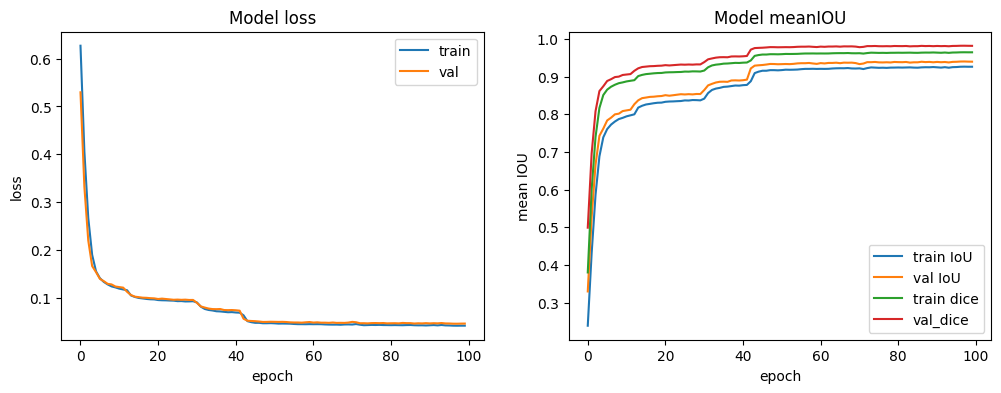

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'])
plt.plot(H['train_DC'])
plt.plot(H['test_DC'])
plt.title('Model meanIOU')
plt.ylabel('mean IOU')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 10:-10,:]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 10:-10,:]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

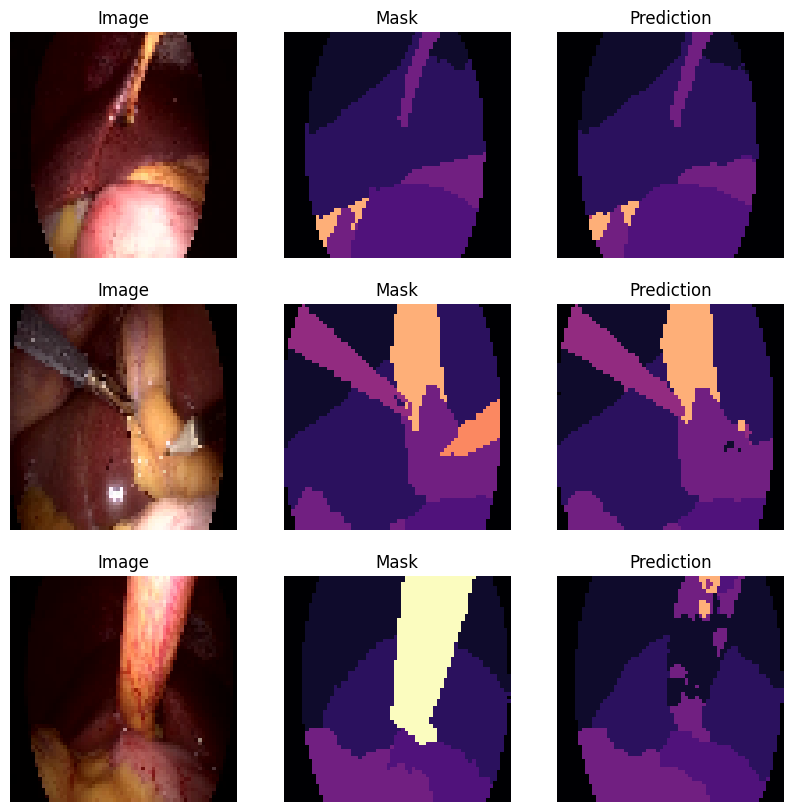

In [21]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota